#### Import

In [ ]:
import easyocr
import os
import torch
import matplotlib.pyplot as plt
import random
import glob
from tqdm import tqdm
import numpy as np
import time
from mmocr_eval import eval_ocr_metric
import re

#### Install packges

In [ ]:
# !pip install matplotlib
# !pip install rapidfuzz

In [ ]:
torch.cuda.is_available()

#### Training

Load model by easyOCR API (https://www.jaided.ai/easyocr/documentation/)

In [ ]:
start = time.time()
model = 'crnn_30k_lr_5e-1'
iteration = 'iter_20000'

model_path = os.path.join('trainer', 'saved_models',model)
reader = easyocr.Reader(lang_list = ['en','th'],
                    model_storage_directory = model_path,
                    user_network_directory = os.path.join('my_model','user_network'),
                    recog_network  = iteration,
                    config_path = 'crnn',
                    gpu = True)
# reader = easyocr.Reader(lang_list = ['en','th'],gpu = True )
end = time.time()
print(f'loading model time: {end - start}')

visualise testing with some image

100%|██████████| 1/1 [00:00<00:00, 10.20it/s]


[([[5.314787143341818, 31.251829714673455], [240.6492779311265, -2.0213012781094837], [246.68521285665818, 46.748170285326545], [11.350722068873495, 80.02130127810949]], 'colonialism.', 0.7289746754044214)]


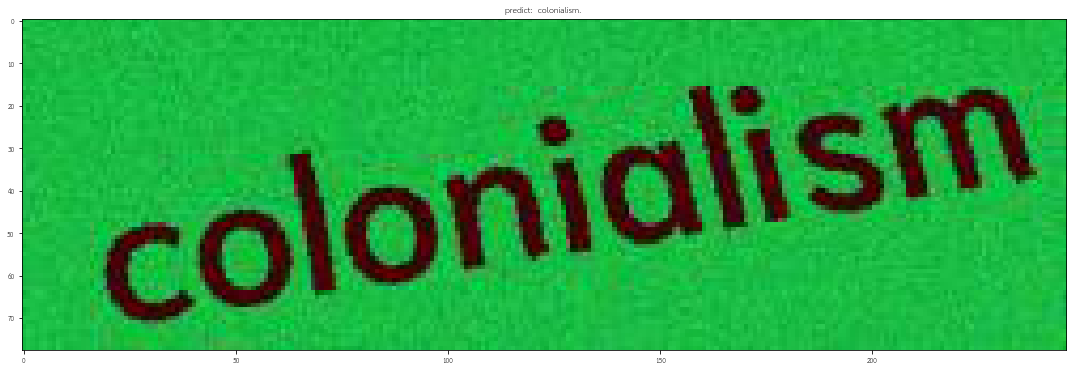

In [129]:
filepaths = glob.glob(os.path.join('trainer/all_data/testing/testing','*.jpg'))
filepaths = sorted(filepaths, key= lambda x: int(re.split(r'[/\\.]',x)[-2]))

plt.rcParams['font.family'] = 'TH Sarabun New'
# plt.rcParams['xtick.labelsize'] = 20.0
# plt.rcParams['ytick.labelsize'] = 20.0
columns = 1
rows = 1
fig = plt.figure(figsize=(15, 15))
ax = []
for i in tqdm(range(columns*rows)):
    # random_file_name = random.sample(os.listdir(os.path.join('trainer/all_data/testing/testing')),1)[0]
    # random_file_path = os.path.join('trainer/all_data/testing/testing',random_file_name)
    #random_file_name = random.sample(os.listdir(os.path.join('trainer/all_data/testing/testing')),1)[0]
    random_file_path = filepaths[27]
    img = plt.imread(random_file_path)
    result = reader.readtext(random_file_path) 
    print(result)
    ax.append(fig.add_subplot(rows, columns, i+1) )
    if len(result) > 0:
        txt = ''
        for i in result:
            txt += (' '+i[1])
        ax[-1].set_title(f'predict: {txt}')
    else:
        ax[-1].set_title('No result')
    plt.imshow(img)
fig.tight_layout() 
plt.show()

In [ ]:
# filepaths = glob.glob(os.path.join('trainer/all_data/testing/testing','*.jpg'))
# label_path = 'trainer/all_data/testing/testing/label.txt'
# with open(label_path, encoding='utf8') as file:
#     label = np.loadtxt(file,dtype=str)
# word_correct = 0

In [ ]:

# plt.rcParams['font.family'] = 'TH Sarabun New'
# columns = 5
# rows = 200
# fig, ax = plt.subplots(rows, columns, figsize=(20, 20))
# ax.set_facecolor("white")
# counter = 0
# for r in tqdm(range(rows)):
#     for c in range(columns):
#         file_name = re.split(r'[/\\]',filepaths[counter])[-1]
#         file_path = os.path.join('trainer/all_data/testing/testing',file_name)
#         img = plt.imread(file_path)
#         ax[r, c].axis('off')
#         result = reader.readtext(file_path) 
#         if len(result) > 0:
#             txt = ''
#             for i in result:
#                 txt += (' '+i[1])
#             ax[r, c].set_title(f'{file_name} predict: {txt}')
#         else:
#             ax[r, c].set_title('No result')
#         ax[r, c].imshow(img)
#         counter += 1
# plt.subplots_adjust(top = 20)

testing with all files in dataset

In [143]:
filepaths = glob.glob(os.path.join('trainer/all_data/testing/testing','*.jpg'))
filepaths = sorted(filepaths, key= lambda x: int(re.split(r'[/\\.]',x)[-2]))
label_path = 'trainer/all_data/testing/testing/label.txt'
with open(label_path, encoding='utf8') as file:
    label = np.loadtxt(file,dtype=str)

start = time.time()
# filepaths = filepaths[:10]
pred = []
gt = [] # ground truth
name_img = []
for i in tqdm(range(len(filepaths))):
    label_img = label[i][1]
    name_img.append(label[i][0])
    result = reader.readtext(filepaths[i], batch_size = 8,detail=0)
    try:
        pred.append(result)
    except:
        pred.append('')
    gt.append(label_img)
end = time.time()
print(f'time: {end - start}')
import mmocr_eval 
from importlib import reload
reload(mmocr_eval)
tmp = name_img.copy()
output, false_list = mmocr_eval.eval_ocr_metric(pred, gt, name_img)
# output, false_list = eval_ocr_metric(pred, gt, name_img)
for k,v in output.items():
    print(f'{k}: {v}')

100%|██████████| 1000/1000 [00:42<00:00, 23.49it/s]

time: 42.581383228302
0.jpg ['วอห์น]่'] 1
0.jpg
1.jpg ['เกรอะ'] 1
2.jpg ['MFC'] 1
3.jpg [] 0
3.jpg
4.jpg ['รภัจฉ์'] 1
4.jpg
5.jpg ['introducema'] 1
5.jpg
6.jpg ['เ่รห'] 1
6.jpg
7.jpg ['พพฒฝ'] 1
7.jpg
8.jpg ['Kenyon'] 1
9.jpg [] 0
9.jpg
10.jpg ['Uses'] 1
11.jpg ['Hermanl'] 1
11.jpg
12.jpg ['ยื๋่น'] 1
12.jpg
13.jpg ['แซงจ์'] 1
14.jpg ['Certrew'] 1
14.jpg
15.jpg ['Salotm'] 1
15.jpg
16.jpg ['ท่ณ'] 1
16.jpg
17.jpg [] 0
17.jpg
18.jpg ["pepsin'"] 1
18.jpg
19.jpg ['experience'] 1
20.jpg ['ทารณ'] 1
20.jpg
21.jpg ['BamlumPoo '] 1
21.jpg
22.jpg ['DRAWN'] 1
23.jpg ['นะะะะ'] 1
24.jpg [] 0
24.jpg
25.jpg ['pearls)'] 1
25.jpg
26.jpg ['Outputs'] 1
27.jpg ['colonialism.'] 1
27.jpg
28.jpg ['นโกฎ-'] 1
28.jpg
29.jpg ['Bl'] 1
29.jpg
30.jpg ['ไพรัชk'] 1
30.jpg
31.jpg [] 0
31.jpg
32.jpg ['Dickinson'] 1
33.jpg ['Rutnin'] 1
34.jpg ['กระทะ'] 1
35.jpg ['Ternary'] 1
36.jpg ['ธิรรมนูญ'] 1
36.jpg
37.jpg ['Divided'] 1
38.jpg ['TECHO'] 1
39.jpg ['แรงดึงดูด'] 1
40.jpg ['water'] 1
41.jpg ['Tokenismw'] 1
41.jpg
42.jpg ['

In [149]:
for key, false in false_list.items():
    print(key, false)

วอห์น ('918.jpg', 'วอหน', 1)
ของ ('920.jpg', 'บอง', 1)
รภัจจ์ ('4.jpg', 'รภัจฉ์', 1)
introduce ('922.jpg', 'introducea', 1)
หากิน ('924.jpg', '', 0)
พิพัฒ ('925.jpg', 'พพฒ', 1)
ลัวส์ ('927.jpg', '', 0)
Herman ('11.jpg', 'Hermanl', 1)
ยิ้น ('931.jpg', 'ยน', 1)
Certre ('14.jpg', 'Certrew', 1)
Salot ('15.jpg', 'Salotm', 1)
ท่อ ('935.jpg', 'ทอ', 1)
ซี่น ('937.jpg', 'ซน', 1)
pepsin ('938.jpg', 'pepsinJ', 1)
ทารก ('940.jpg', 'ทอร่ม', 1)
Bamlumpoo ('941.jpg', 'Bamlumpoo ', 1)
ภมูธ ('943.jpg', 'T', 1)
pearls ('25.jpg', 'pearls)', 1)
colonialism ('27.jpg', 'colonialism.', 1)
นโกฎ ('28.jpg', 'นโกฎ-', 1)
Blunt ('29.jpg', 'Bl', 1)
ไพรัช ('30.jpg', 'ไพรัชk', 1)
บั้นท้าย ('31.jpg', '', 0)
ธรรมนูญ ('36.jpg', 'ธิรรมนูญ', 1)
Tokenism ('960.jpg', 'Tokenismw', 1)
บพีท ('44.jpg', 'บพีท ', 1)
Rebec ('964.jpg', 'Rebecw', 1)
ตรวจสอบ ('47.jpg', 'ตรวลสอบ', 1)
Overheating ('48.jpg', '', 0)
เอียร์ ('49.jpg', 'เอ็ยร]ุ', 1)
make ('51.jpg', 'Iake', 1)
ฟลอริดา ('970.jpg', 'ฟลอริดา ', 1)
ท้ำ ('55.jpg', '', 0)
iPhone 

testing with LMWN

In [ ]:
plt.rcParams['font.family'] = 'TH Sarabun New'
plt.rcParams['xtick.labelsize'] = 20.0
plt.rcParams['ytick.labelsize'] = 20.0
columns = 2
rows = 10
fig = plt.figure(figsize=(10, 10))
ax = []
for i in range(columns*rows):
    random_file_name = random.sample(os.listdir(os.path.join('trainer/all_data/testing/LMWN')),1)[0]
    # random_file_path = os.path.join('trainer/all_data/testing/testing',random_file_name)
    #random_file_name = random.sample(os.listdir(os.path.join('trainer/all_data/testing/testing')),1)[0]
    # random_file_name = os.listdir(os.path.join('trainer/all_data/testing/LMWN'))[2]
    random_file_path = os.path.join('trainer/all_data/testing/LMWN',random_file_name)
    img = plt.imread(random_file_path)
    result = reader.readtext(random_file_path,detail=0) 
    ax.append(fig.add_subplot(rows, columns, i+1) )
    if len(result) > 0:
        ax[-1].set_title(f'predict: {result}',fontsize=20)
    else:
        ax[-1].set_title('No result',fontsize=20)
    plt.imshow(img)
fig.tight_layout() 
plt.show()